In [ ]:
# https://www.analyticsvidhya.com/blog/2020/05/tutorial-real-time-lane-detection-opencv/

In [1]:
import os
import re
import cv2
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [2]:
"""
각종 경로 설정하기
"""
# 이미지 파일 상태인, 도로 사진
dir_path_img_frames_read = 'resource/frames1/'

# 차선 탐지가 된 도로 사진을 저장할 폴더
dir_path_img_frames_write = 'resource/frames1_detected/'

# 차선 탐지가 된 도로 사진을 동영상으로 만들어서 저장할 결과물
dir_path_video_out = 'resource/'
video_out_filename = 'output.mp4'

print('done')

done


In [3]:
"""
주요 파라미터 설정하기
"""
target_height = 270
target_width = 480

In [4]:
"""
Read Video Frames
비디오 : https://www.youtube.com/watch?reload=9&v=KWJaBJYJIjI
Frames : 비디오 촬영 영상을 연속된 이미지로 변경 해 놓은 것 (사진파일 다수)
"""

dir_path_img_frames_read = 'resource/frames1/'
col_frames = os.listdir(dir_path_img_frames_read)
col_frames.sort(key=lambda f: int(re.sub('\D', '', f)))

# load frames
col_images=[]
for i in tqdm_notebook(col_frames):
    img = cv2.imread(dir_path_img_frames_read + i)
    col_images.append(img)


# 이미지를 고정된 크기로 변경
img = col_images[0]
height, width = img.shape[:2]
if (height != target_height) or (width != target_width):
    img = img.resize(img, dsize=(target_width, target_height))

# 읽어온 사진 파일 검증
num_images = len(col_images)
height, width = col_images[0].shape[:2]
print('num images read : ', num_images)
print('image shape : ', height, width)
print('done')

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]



num images read :  1108
image shape :  270 480
done


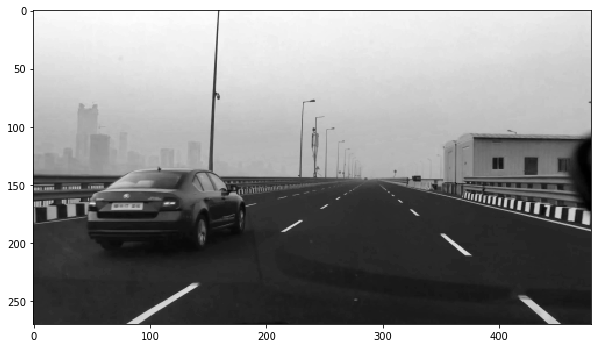

done


In [5]:
# 읽어온 사진 중에서 랜덤으로 하나 골라서 화면에 출력하기

import random
%matplotlib inline

# specify frame index
idx = random.randint(0, num_images)

# plot frame
plt.figure(figsize=(10,10))
plt.imshow(col_images[idx][:,:,0], cmap= "gray")
plt.show()

print('done')

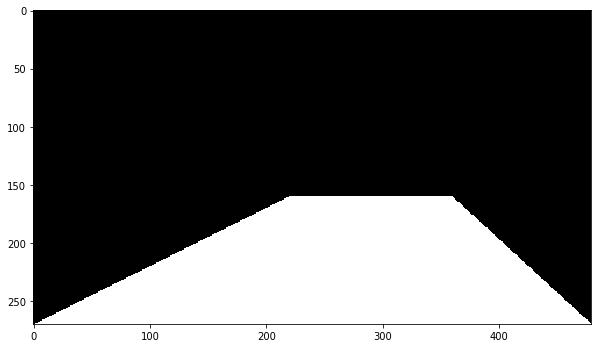

done


In [6]:
"""
Frame Mask Creation : 관심없는 부분은 검은색으로 덮어버리는 부분
즉, 바로 앞에 있는 차선 부분을 제외하고는 모두 검은색으로 덮어서,
차선 탐지가 더 잘 되도록...
Our region of interest is in the shape of a polygon. 
We want to mask everything except this region. 
Therefore, we first have to specify the coordinates of the polygon 
and then use it to prepare the frame mask:
"""

# create a zero array
stencil = np.zeros_like(col_images[idx][:,:,0])

# specify coordinates of the polygon
#
# 촬영한 영상에 따라서 다각형의 형태를 조절할 필요가 있겠다.
#
polygon = np.array([[0,270], [220,160], [360,160], [480,270]])

# fill polygon with ones
cv2.fillConvexPoly(stencil, polygon, 1)

# 결과를 화면에 표시 : 아무것도 없는 화면에 다각형의 흰색 + 나머지 검은색 생성
# plot polygon
plt.figure(figsize=(10,10))
plt.imshow(stencil, cmap= "gray")
plt.show()

print('done')

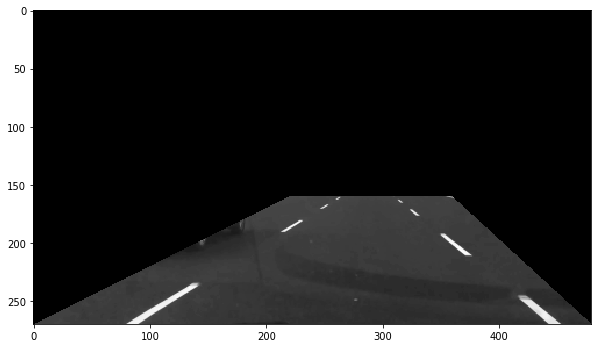

done


In [7]:
# 이렇게 생성한 다각형을, 실제 도로 사진 위에 덮기
# apply polygon as a mask on the frame
img = cv2.bitwise_and(col_images[idx][:,:,0], col_images[idx][:,:,0], mask=stencil)

# plot masked frame
plt.figure(figsize=(10,10))
plt.imshow(img, cmap= "gray")
plt.show()

print('done')

In [8]:
"""
다음 작업은 Image pre-processing
e Pre-processing
We have to perform a couple of image pre-processing operations 
on the video frames to detect the desired lane. 
The pre-processing operations are:
1) Image Thresholding
2) Hough Line Transformation
"""

'\n다음 작업은 Image pre-processing\ne Pre-processing\nWe have to perform a couple of image pre-processing operations \non the video frames to detect the desired lane. \nThe pre-processing operations are:\n1) Image Thresholding\n2) Hough Line Transformation\n'

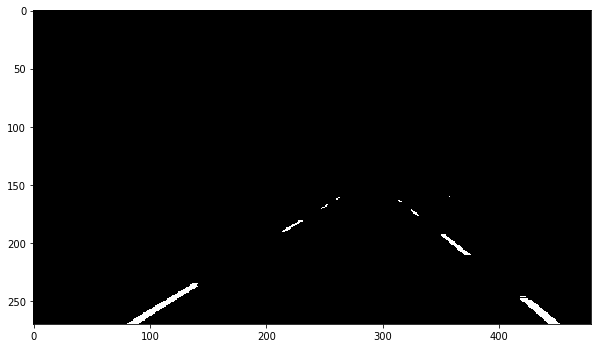

done


In [9]:
"""
1. Image Thresholding
카메라로 획득한 사진을 gray-scale로 변환한 다음에 threshold 기반의 변환 기법을 사용함
즉, [이미지 픽셀값 >= threshold] 이면 한가지 색으로 변환하고
나머지 경우에는 다른 색으로 변환해서, 
이미지를 단순화 하고, 차선 탐지를 쉽게 만들기
"""

# apply image thresholding
ret, thresh = cv2.threshold(img, 130, 145, cv2.THRESH_BINARY)

# plot image
plt.figure(figsize=(10,10))
plt.imshow(thresh, cmap= "gray")
plt.show()

print('done')

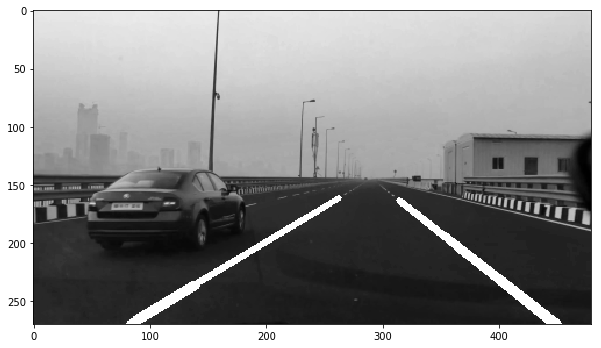

done


In [10]:
"""
2. Hough Line Transformation
차선 탐지
"""

# https://m.blog.naver.com/windowsub0406/220894462409
# 흑백으로 변환된 이미지만 입력으로 받을 수 있음
lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 30, maxLineGap=200)

# create a copy of the original frame
dmy = col_images[idx][:,:,0].copy()

# draw Hough lines
for line in lines:
  x1, y1, x2, y2 = line[0]
  cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 3)

# plot frame
plt.figure(figsize=(10,10))
plt.imshow(dmy, cmap= "gray")
plt.show()

print('done')

In [11]:
"""
위의 2개 과정 (threshold => hough transf) 을 모든 사진 프레임에 적용
"""
cnt = 0

for img in tqdm_notebook(col_images):
    # apply frame mask
    masked = cv2.bitwise_and(img[:,:,0], img[:,:,0], mask=stencil)
  
    # apply image thresholding
    ret, thresh = cv2.threshold(masked, 130, 145, cv2.THRESH_BINARY)

    # apply Hough Line Transformation
    # HoughLinesP : Probabilistic Hough Transform
    # https://opencv-python.readthedocs.io/en/latest/doc/
    #         25.imageHoughLineTransform/imageHoughLineTransform.html
    lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 30, maxLineGap=200)
    dmy = img.copy()
  
    # Plot detected lines
    try:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 3)
  
        cv2.imwrite(dir_path_img_frames_write+str(cnt)+'.png',dmy)
  
    except TypeError: 
        cv2.imwrite(dir_path_img_frames_write+str(cnt)+'.png',img)

    cnt+= 1

print('done')

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



done


In [ ]:
"""
차선 탐지된 이미지를 묶어서 비디오로 만들기 (1/3)

dir_path_img_frames_read = 'resource/frames1/'
dir_path_img_frames_write = 'resource/frames1_detected/'
dir_path_video_out = 'resource/'
video_out_filename = 'output.mp4'
"""
dir_path_video_out = 'resource/'
video_out_filename = 'output.mp4'

# specify frames per second
fps = 30.0

from os.path import isfile, join

# get file names of the frames
files = [f for f in os.listdir(dir_path_img_frames_write) 
         if isfile(join(dir_path_img_frames_write, f))]
files.sort(key=lambda f: int(re.sub('\D', '', f)))

print('done')

In [ ]:
# 차선 탐지된 이미지를 묶어서 비디오로 만들기 (2/3)
# Next, we will get all the frames with the detected lane into a list:

frame_list = []

for i in tqdm_notebook(range(len(files))):
    filename = dir_path_img_frames_write + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_list.append(img)
    
print('done')    

In [ ]:
# 차선 탐지된 이미지를 묶어서 비디오로 만들기 (3/3)
# Finally, we can now combine the frames into a video by using the code below:

# write the video
path_out = dir_path_video_out + video_out_filename
out = cv2.VideoWriter(path_out,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for i in range(len(frame_list)):
    # writing to a image array
    out.write(frame_list[i])

out.release()

print('done')